# Synthetic Quantum Electrodynamics via Generative AI
# Part II/V -- AI Theory

$
\large
\text{Mikael Mieskolainen}
$

$
\text{Department of Physics and I-X Centre for AI in Science, Imperial College London}
$

$
\tiny
\texttt{m.mieskolainen@imperial.ac.uk}
$

<a href="https://github.com/mieskolainen">github.com/mieskolainen</a>

<br>

$
\text{May, 2025}
$

**Abstract**

We learn the basic theory and computations behind the generative AI models under discussion, namely, normalizing flows and discrete-time and continuous-time (SDE) diffusion models, and discuss their connection to continous normalizing flows (ODE) and flow matching.

<br>
<br>

**Outline:**

- [Part I: Physics Theory](tutorial_part_1.ipynb)
- [Part II: AI Theory](tutorial_part_2.ipynb)
- [Part III: Surrogate Simulator](tutorial_part_3.ipynb)
- [Part IV: Amortized Bayesian Posterior](tutorial_part_4.ipynb)
- [Part V: Deep Inverse Problems](tutorial_part_5.ipynb)

<br>
<br>

<div style="display: flex; flex-wrap: wrap; justify-content: space-between; gap: 10px;">
  <img src="img/scattering_simulation.jpeg" style="width: 49%; height: auto;">
  <img src="img/OU_simulation.jpeg" style="width: 49%; height: auto;">
</div>

> **Compatibility: Use VSCode with Jupyter extension (better LaTex rendering) or JupyterLab. Hit refresh [F5] if the notebook freezes.**


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# Run this first if using Colab
"""
!git clone https://github.com/mieskolainen/AIMS25.git
%cd AIMS25
"""
import sys
sys.path.append('./xaims')

# !pip install -r requirements.txt

<br>

---
## Goals Behind Generative AI

**Synthesizing Physical Reality?**

There are several ways of using generative AI. Most of them are about computational tractability (acceleration) and handling large-dimensional spaces:

- **Data-Theory hybrid model**: AI is used to **augment** the physics theory, e.g. learn non-perturbative (difficult or uncomputable) pieces of the theory equations.

- **Surrogate or synthetic model**: A generative model learns how to sample collision events according to the original simulator distribution $p(\mathbf{x})$, as it were any other distribution. That is, a synthetic Monte Carlo event generator surrogate $\tilde{p}(\mathbf{x})$. *Does not guarantee unbiased results against the original simulator by construction, but can be a very fast generator in higher dimensions*.

- **Neural Importance Sampling**: A generative model is used to learn a **proposal density** $q(\mathbf{x})$ for Monte Carlo importance sampling, to improve the MC generator sampling efficiency and improve sampling variance, but keep the simulator otherwise intact. *Formally unbiased, because $q(\mathbf{x})$ can be only a rough estimate of $p(\mathbf{x})$, as long as $q(\mathbf{x}) > 0$ when $p(\mathbf{x}) > 0$ (which is not necessarily a fully trivial requirement)*. Requires a generative model which has both sampling and exact density evaluation properties.

$
\mathbb{E}_{p}[f(\mathbf{x})] = \int f(\mathbf{x})\,p(\mathbf{x})\,d\mathbf{x} = \int f(\mathbf{x})\,\frac{p(\mathbf{x})}{q(\mathbf{x})}\,q(\mathbf{x})\,d\mathbf{x}
$

$
\mathbb{E}_{p}[f(\mathbf{x})] \approx \frac{1}{N} \sum_{i=1}^{N} f(\mathbf{x}_i)\, \frac{p(\mathbf{x}_i)}{q(\mathbf{x}_i)}, \quad \mathbf{x}_i \sim q(\mathbf{x})
$

<br>

**Topics covered in the code notebooks:**

- Part III: **Conditional Surrogate of the Simulator** $\sim p(\mathbf{x} \mid \theta)$

- Part IV: **Amortized Bayesian Posterior** $\sim p(\theta \mid \mathbf{x})$

- Part V: **Deep Inverse Problems**

<br>

**Homework:** Do research on different ways of using generative AI. Computation acceleration, high-dimensional inference, "symbolic learning", discovery of new theories and new phenomena, learning models directly from data ...


<br>

---

## Conditional Normalizing Flows

[xaims/flows.py](xaims/flows.py) | [xaims/splines.py](xaims/flows.py)

A function $f: X \rightarrow Z$ is a **bijection** iff:

1. Injective (one-to-one): If $f(\mathbf{x}_1) = f(\mathbf{x}_2)$, then $\mathbf{x}_1 = \mathbf{x}_2$.
2. Surjective (onto): For every $\mathbf{x} \in X$, there exists $\mathbf{z} \in Z$, such that $f(\mathbf{x}) = \mathbf{z}$.

A function is invertible if and only if it is bijective.

<img src="img/flow.png" width="50%"/>

<a href="https://arxiv.org/abs/1605.08803">Dinh et al., *Density estimation using Real NVP*, [arXiv:1605.08803]</a>

> Note: The picture above and many papers use a reverse notation, i.e. $f$ for us is $f^{-1}$.

### Multivariate change of variables

**Forward**

Let us define the forward direction by $\mathbf{z} = f(\mathbf{x})$. Then given this is an invertible map, we get

$
\log p_X(\mathbf{x}) = \log p_Z \left( f(\mathbf{x}) \right) + \log \left|\det \frac{\partial f}{\partial x}(\mathbf{x}) \right|,
$

where the second term is a log-absolute Jacobian determinant, which needs to be efficient to evaluate with normalizing flows.

**Inverse**

To get from $\mathbf{z}$ back to $\mathbf{x}=f^{-1}(\mathbf{z})$, we have

$
\log p_Z(\mathbf{z})
= \log p_X \left(f^{-1}(\mathbf{z})\right) + \log \left|\det \frac{\partial f^{-1}}{\partial z}(\mathbf{z}) \right|
= \log p_X \left(f^{-1}(\mathbf{z})\right) - \log \left|\det \frac{\partial f}{\partial x} \left(f^{-1}(\mathbf{z}) \right) \right|.
$

**Normalizing Flow**

A normalizing flow model consists of a chain of $K$ invertible, learned transformations:

$
\mathbf{z} = f(\mathbf{x}) = f_K \circ f_{K-1} \circ \dots \circ f_1(\mathbf{x}),
$

with:
- $ \mathbf{x} \in \mathbb{R}^D $: data sample
- $ \mathbf{z} \sim p_Z(\mathbf{z}) $: base distribution with a tractable PDF, typically a diagonal covariance multidimensional Gaussian
- $ f_k : \mathbb{R}^D \rightarrow \mathbb{R}^D $: each invertible transformation.
- $\mathbf{y}_0 = \mathbf{x},\quad \mathbf{y}_k = f_k(\mathbf{y}_{k-1}) \quad k=1,\dots,K, \quad \mathbf{y}_K = \mathbf{z}$

Then the data log‑density becomes

$
\boxed{
\log p_X(\mathbf{x}) = \log p_Z(\mathbf{z}) + \sum_{k=1}^K \log \left |\det \frac{\partial f_k}{\partial \mathbf{y}_{k-1}} \left(\mathbf{y}_{k-1} \right) \right|.
}
$

This gives us directly also our **Negative Log-Likelihood** loss function via the max likelihood principle:

$
\mathcal{L}_{\text{NLL}}(\theta) = \mathbb{E}_{\mathbf{x}\sim p_{\text{data}}} \left[ - p_{X, {\theta}}(\mathbf{x}) \right]
$

That is, this expectation is a sum over the events of the (mini)batch. This is exactly the same criteria as in classic frequentist inference. We just fit a neural network.

Note that this is equivalent to minimizing **forward Kullback-Leibler (KL) divergence** 

$
KL_F(p_{\text{data}} \mid p_{\theta}) = E_{p_{\text{data}}} \left[ \log \frac{p_{\text{data}}(\mathbf{x})}{p_{\theta}(\mathbf{x})} \right],
$

up to the constant term $\log p_{\text{data}}(\mathbf{x})$ which does not depend on the network parameters ${\theta}$.

<br>

---
## Reverse KL and Neural Importance Sampling

<details>
<summary><span style="color: red">Details about IS (expand)</span></summary>

<br>

Assume we have an access to a physics simulator, but it has a very inefficient sampling routine -- simple uniform sampling & acceptance-rejection unweighting is not really practical in higher dimensions. So would be nice to train a normalizing flow as a **Neural Importance Sampling** model to obtain an importance sampling proposal $q_\phi(\mathbf{x})$ which minimizes the variance of the importance weights, in order provide an efficient sampling algorithm. All this while simultaneously in-the-training-loop evaluating the unnormalized physics density

$
\tilde{p}(\mathbf{x}) \propto \text{phase space}(\mathbf{x}) \times |M(\mathbf{x})|^2.
$

For this chicken-egg problem, a suitable loss is the **Reverse KL**:

$
KL_R(q_\phi \mid \tilde{p}) = E_{q_\phi(\mathbf{x})} \left[ \log \frac{q_\phi(\mathbf{x})}{\tilde{p}(\mathbf{x})} \right].
$

**Training loop ingredients**:

```python
# Sample from the generative AI model
x = flow.sample((N,))                # x ~ q_phi(x), this is our IS proposal, properly normalized

# Compute log-probs
log_q       = flow.log_prob(x)       # IS proposal density
log_p_tilde = unnormalized_log_p(x)  # log(phase-space x scattering amplitude weight)

# Reverse KL loss: E_q[log q - log \tilde{p}]
loss = (log_q - log_p_tilde).mean()
```

In the case of event generators, it is common that $\mathbf{x} \in [0,1]^d$ and then a shift and scale is applied per dimension, for example:

$t = t_\min + (t_\max - t_\min) x$, where $t$ is the Mandelstam t.

All the previous discussion about the event generator holds similarly, we just learn a neural IS proposal.

</details>

---

### External variable conditioning

In a **conditional flow**, each transformation $ f_k $ may depend on an external variable $ c $, for example the center-of-mass energy. This is incorporated as an extra input for the neural networks, and it does not complicate the Jacobian determinant structure.

With high-dimensional, categorical or otherwise complicated $c$, a separate learnable pre-embedding network $\varphi(c) = \tilde{c}$ may be useful to add to each flow layer.

---

## Coupling Flow Architecture

Because the normalizing flows need to have invertible structure with a fast Jacobian, this limits the possible architecture choises. Coupling layer type flows first splits input vectors into two parts dimension wise as follows.

The input $ \mathbf{x} \in \mathbb{R}^D $ using a binary mask $ \mathbf{m} \in \{0,1\}^D$, is split into two $\sim D/2$ dimensional subvectors:

- $ \mathbf{x}_1 = \mathbf{x}[\mathbf{m}] $
- $ \mathbf{x}_2 = \mathbf{x}[1 - \mathbf{m}] $

This structuring allows to design a flow architecture with a **triangular Jacobian structure**, which has computationally a very efficient determinant with $O(D)$ time complexity, namely the product (log sum) of the diagonal elements. A full Jacobian would have $O(D^3)$, due to the matrix inversion.

In between multiple flow layers, we do **permutation** of the masks to allow the network learn the dimension wise correlation structures (two-point and higher order).

---

#### RealNVP Affine Flow

In this model, per flow layer only $ \mathbf{x}_2 $ is transformed, conditioned on $ \mathbf{x}_1 $ and the external conditional variable $ c $.

The masking design ensures that part of the input passes through unchanged and conditions the transformation of the other part.
 
<img style="background-color: white" src="img/realnvp_coupling.png" width="40%"/>

<a href="https://arxiv.org/abs/1605.08803">Dinh et al., *Density estimation using Real NVP*, [arXiv:1605.08803]</a>

> RealNVP coupling diagram: scale, shift, identity branches.


##### Forward

$
\mathbf{y}_1 = \mathbf{x}_1
$

$
\mathbf{y}_2 = \mathbf{x}_2 \odot \exp\left( s_\theta(\mathbf{x}_1, c) \right) + t_\theta(\mathbf{x}_1, c)
$

$
\boxed{
\mathbf{y} = \mathbf{y}_1 \oplus \mathbf{y}_2 \in \mathbb{R}^D
}
$

where $\oplus$ denotes indexing based reconstruction back to the original vector space dimension.


##### Inverse

$
\mathbf{x}_1 = \mathbf{y}_1
$

$
\mathbf{x}_2 = \left( \mathbf{y}_2 - t_\theta(\mathbf{y}_1, c) \right) \odot \exp\left( -s_\theta(\mathbf{y}_1, c) \right)
$

$
\boxed{
\mathbf{x} = \mathbf{x}_1 \oplus \mathbf{x}_2  \in \mathbb{R}^D
}
$

##### Jacobian

Block-triangular:

$
\frac{\partial \mathbf{y}}{\partial \mathbf{x}} =
\begin{bmatrix}
\mathbf{I} & \mathbf{0} \\
* & \text{diag}\left( \exp(s_\theta(\mathbf{x}_1, c)) \right)
\end{bmatrix}
$

The corresponding log-absolute Jacobian determinant of the layer is:

$
\boxed{
\log \left| \det \left( \frac{\partial \mathbf{y}}{\partial \mathbf{x}} \right) \right| = \sum_{i=1}^d s_\theta^i (\mathbf{x}_1, c)
}
$

Above, $s_\theta$ and $t_\theta$ are the **scale** and **translation** neural networks and each flow layer has their own.

---

#### Neural Spline Flows

<a href="https://arxiv.org/abs/1906.04032">Durkan et al., *Neural Spline Flows*, [arXiv:1906.04032]</a>

Instead of the affine model, we may use also **monotonic piecewise polynomials**, e.g., rational quadratic splines (RQS), in the flow. We do not go into the details of how to construct the spline transform itself in a numerically stable way (see the code). But the key point is that their transformation is invertible vector element wise and they can be incorporated in autograd compatible way into the network.

The basic idea is that neural networks $\phi_{1,2}$ are trained to map the input into **spline parameters**: bin widths, heights, and slopes, and then the spline transform is applied. See the code for the spline parameter post-transformations with a softmax and softplus functions applied to the network output.

##### Forward

$
\mathbf{y}_2 = \text{spline}_\theta\left( \mathbf{x}_2; \phi_1(\mathbf{x}_1, c) \right)
$

$
\mathbf{y}_1 = \text{spline}_\theta\left( \mathbf{x}_1; \phi_2(\mathbf{y}_2, c) \right)
$

$
\boxed{
\mathbf{y} = \mathbf{y}_1 \oplus \mathbf{y}_2 \in \mathbb{R}^D
}
$

##### Inverse

$
\mathbf{x}_1 = \text{spline}_\theta^{-1}\left( \mathbf{y}_1; \phi_2(\mathbf{x}_2, c) \right)
$

$
\mathbf{x}_2 = \text{spline}_\theta^{-1}\left( \mathbf{y}_2; \phi_1(\mathbf{x}_1, c) \right)
$

$
\boxed{
\mathbf{x} = \mathbf{x}_1 \oplus \mathbf{x}_2 \in \mathbb{R}^D
}
$

##### Jacobian

Block-triangular:

$
\frac{\partial \mathbf{y}}{\partial \mathbf{x}} =
\begin{bmatrix}
\mathrm{diag}\left( \frac{\partial \mathbf{y}_1^i}{\partial \mathbf{x}_1^i} \right) & \mathbf{0} \\
\ast & \mathrm{diag}\left( \frac{\partial \mathbf{y}_2^j}{\partial \mathbf{x}_2^j} \right)
\end{bmatrix}
$

The corresponding log-absolute Jacobian determinant of the layer is:

$
\log \left| \det \left( \frac{\partial \mathbf{y}}{\partial \mathbf{x}} \right) \right| = \sum_{i} \log \left( \frac{\partial \mathbf{y}_1^i}{\partial \mathbf{x}_1^i} \right) + \sum_{j} \log \left( \frac{\partial \mathbf{y}_2^j}{\partial \mathbf{x}_2^j} \right)
$

---

Both type of flows presented here allow **invertibility** and **exact log-density computation**, which are key features of flow-based models. However, their modelling capacity and flexibility is somewhat limited by these two exact properties.

Next we take a look at currently the most popular **continuous variable** generative modelling, which are the **diffusion models**. The most popular **discrete variable** models are currently based on **GPT architectures**, famous from the Large Language Models.

<br>

---
## Discrete-Time Diffusion Model

[xaims/ddpm.py](xaims/ddpm.py)

### DDPM

We first study a *discrete-time diffusion* approach known as Denoising Diffusion Probabilistic Model (DDPM), which is a popular especially in the image generation field.

Then later, we inspect *continuous-time diffusion* with SDEs which have formally infinite number of time-steps, and are perhaps a more flexible framework for science applications.

<img src="img/DDPM.png" width="60%"/>

<a href="https://arxiv.org/abs/2006.11239">[arXiv:2006.11239] Ho el al., *Denoising Diffusion Probabilistic Models (DDPM)*</a>

<a href="https://arxiv.org/abs/2010.02502">[arXiv:2010.02502] Song et al., *Denoising Diffusion Implicit Models (DDIM)*</a>

> Note: We use index $k$ here instead of $t$, to emphasize the discrete-time process.

### A. Forward Process (Noising)

We define a forward noising process that gradually adds Gaussian noise to a data point $\mathbf{x}_0$ over $T$ steps:

$
q(\mathbf{x}_{1:T} \mid \mathbf{x}_0) = \prod_{k=1}^{T} q(\mathbf{x}_k \mid \mathbf{x}_{k-1}), \, \text{where} \quad q(\mathbf{x}_k \mid \mathbf{x}_{k-1}) = \mathcal{N}(\mathbf{x}_k; \sqrt{\alpha_k} \mathbf{x}_{k-1}, (1 - \alpha_k)\mathbf{I})
$

Let

$
\bar{\alpha}_k = \prod_{i=1}^k \alpha_i
$

Then the marginal density of $\mathbf{x}_k$ given $\mathbf{x}_0$ has a **closed-form**:

$
\boxed{
q(\mathbf{x}_k \mid \mathbf{x}_0) = \mathcal{N}\left(\mathbf{x}_k; \sqrt{\bar{\alpha}_k} \mathbf{x}_0, (1 - \bar{\alpha}_k)\mathbf{I} \right)
}
$

This *bar trick* allows us to "jump" to $\mathbf{x}_k$ directly from $\mathbf{x}_0$ using:

$
\mathbf{x}_k = \sqrt{\bar{\alpha}_k} \mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_k} \, \epsilon, \quad \epsilon \sim \mathcal{N}(0, \mathbf{I})
$

This is very useful for the training phase.

### B. Reverse Process (Denoising)

We **learn** a reverse-time Markov process:

$
p_\theta(\mathbf{x}_{0:K}) = p(\mathbf{x}_K) \prod_{k=1}^{K} p_\theta(\mathbf{x}_{k-1} \mid \mathbf{x}_k, c).
$

Each transition probability is desribed by

$
p_\theta(\mathbf{x}_{k-1} \mid \mathbf{x}_k, c) = \mathcal{N}(\mathbf{x}_{k-1}; \mu_\theta(\mathbf{x}_k, k, c), \Sigma_\theta(\mathbf{x}_k, k, c)).
$

In practice, the covariance matrix $\Sigma_\theta$ is typically fixed by the schedule design (see e.g. the sampling procedure), and the **focus is on learning only** $\mu_\theta$.

Like with normalizing flows, the external conditional variable $c$ dependence is implemented by injecting $c$ into the neural network.

---

### Neural Network Parameterization

The network input will be the current state $x$ concatenated with the normalized time and the condition $c$.

We parameterize the model to predict the **added noise** $\epsilon$ from the forward process, where the network $\epsilon_\theta(\mathbf{x}_k, k, c)$ approximates $\epsilon$. That is, the neural model learns a map

$
\epsilon_{\theta}(\mathbf{x}_k, k, c): \mathbb{R}^{D_X \times D_T \times D_C} \rightarrow \mathbb{R}^{D_X}.
$

The neural network takes inputs:
- $\mathbf{x}_k$: noisy input
- $k$: timestep, often 'embedded' with $D_k > 1$ for better performance (e.g., sinusoidal map or a learned embedding)
- $c$: external conditioning (e.g. CM energy, discrete labels)

> Note: Non-fixed dimensional $D_X$ generative task can be also implemented by doing *latent diffusion*.
> In that case we have a separate **encoder-decoder** model. Such problems are typical with complicated processes with a variable number of final state particles per collision event.

### Diffusion Process Hyperparameters

We use a noise schedule with diffusion steps $k \in \{1, \dots, T\}$, where $k=1$ is the noise free and $k=T$ the fully noisy (Gaussian) and define

$
\boxed{
\beta_k, \quad \beta_k = 1 - \alpha_k, \quad \bar{\alpha}_k=\prod_{i=1}^{k}\alpha_i, \quad \bar{\alpha}_0 := 1.
}
$

> **Note:** Read the original DDPM paper for a derivation of these.

---

### A. Training Procedure


For each batch we sample a random timestep $k$ and add Gaussian noise $\epsilon$ to the data $\mathbf{x}_0$ according to

$
\boxed{
\mathbf{x}_k=\sqrt{\bar{\alpha}_k}\,\mathbf{x}_0 + \sqrt{1-\bar{\alpha}_k}\,\epsilon,
}
$

where $x_0 \sim \text{training data}$.

The training loss used in most implementations is a **noise predictor**:

$
\boxed{
\mathcal{L}_{\text{simple}}(\theta) = \mathbb{E}_{\mathbf{x}_0, \epsilon, k} \left[ \| \epsilon - \epsilon_\theta(\mathbf{x}_k, k, c) \|^2 \right]
}
$

Where the expectation is over:
- $k \sim \text{Uniform}\{1, \dots, T\}$
- $\epsilon \sim \mathcal{N}(0, \mathbf{I})$

### B. Sampling Procedure

To generate a sample:

1. Sample:
$
\mathbf{x}_T \sim \mathcal{N}(0, \mathbf{I})
$

2. For each $ k = T, T-1, \dots, 1 $:

    - Compute the mean:
    $
    \mu_k = \frac{1}{\sqrt{\alpha_k}} \left( \mathbf{x}_k - \frac{\beta_k}{\sqrt{1 - \bar{\alpha}_k}} \epsilon_\theta(\mathbf{x}_k, k, c) \right)
    $

    - Compute the variance:
    $
    \sigma_k^2 = \begin{cases}
    \frac{1 - \bar{\alpha}_{k-1}}{1 - \bar{\alpha}_k} \beta_k & \text{if } k > 1 \\
    0 & \text{if } k = 1
    \end{cases}
    $
    
    - Sample:
    $
    \mathbf{x}_{k-1} \sim \mathcal{N}(\mu_k, \sigma_k^2 \mathbf{I})
    $

3. Return:
$
\mathbf{x}_0
$

---

> Note: The exact posterior variance of the reverse transition is often defined in the approximate way, i.e. $\bar{\alpha}_{k-1} \approx \bar{\alpha}_{k}$ which gives $\sigma_k^2 = \sqrt{\beta_k}$.

> Later recent work has proposed *learned variance* formulations, instead using a fixed variance.

<br>

---

## Score Matching

Score matching is a fundamental technique introduced by Hyvärinen in 2005, to estimate (implicit) pdf models which we can compute only up to a multiplicative normalization constant $Z(\theta)$. Which means if $p_{\theta}(\mathbf{x}) = h_{\theta}(\mathbf{x}) / Z(\theta)$, our neural model would provide only $h_{\theta}(\mathbf{x})$.

The key starting point is the data score vector

$\boxed{
s(\mathbf{x}) \equiv \nabla_x\log p_\theta(\mathbf{x})
}
$

which has no dependence on $Z(\theta)$ due to the gradient wrt $\mathbf{x}$.

**Hyvärinen Score Matching**

The score matching starts with the Fisher divergence

$
D = \frac12\int p(\mathbf{x}) \, \left \|\nabla_{\mathbf{x}} \log p(\mathbf{x}) \; - \; \nabla_{\mathbf{x}} \log p_\theta(\mathbf{x}) \right\|^2 \, d\mathbf{x}.
$

Now the main problem with this is that we do **not** have a direct access to $p(\mathbf{x})$, which is our data density. However, with some algebra, one gets the HSM objective:

$
\boxed{
\text{arg min}_{\theta} \;\; L_{\text{HSM}}(\theta) = \mathbb{E}_{p(\mathbf{x})} \left[\, \| \nabla_{\mathbf{x}} \log p_{\theta}(\mathbf{x})\|^2 + 2 \, \Delta_{\mathbf{x}} \log p_{\theta}(\mathbf{x}) \right]
}
$

A computationally tractable way to optimize this with neural networks in high-dimensions is **Sliced Score Matching**, which uses the Hutchinson trace estimator for the Laplacian $\Delta_{\mathbf{x}}=\mathrm{Tr}(\nabla_{\mathbf{x}}^2)$.

**Vincent Denoising Score Matching**

Denoising Score Matching find the relation between noise and the score by inspecting a conditional density $q_\sigma(\tilde{\mathbf{x}} \mid \mathbf{x})$ which represents the noising process. The difference $\tilde{\mathbf{x}} - \mathbf{x} \equiv \epsilon$ is the added noise. Typically, this is a Gaussian distribution centered at the original data point $x$ such that $q_\sigma(\tilde{\mathbf{x}} \mid \mathbf{x}) = \mathcal{N}(\tilde{\mathbf{x}} \mid \mu = \mathbf{x}, \sigma^2 I)$.

Given this, the objective is written as

$
\arg\min_{\theta} \; L_{\text{DSM}}(\theta) = \mathbb{E}_{p(\mathbf{x})} \, \mathbb{E}_{q_{\sigma}(\tilde{\mathbf{x}} \mid \mathbf{x})} \left[ \left\| \nabla_{\tilde{\mathbf{x}}} \log p_{\theta}(\tilde{\mathbf{x}}) - \nabla_{\tilde{\mathbf{x}}} \log q_{\sigma}(\tilde{\mathbf{x}} \mid \mathbf{x}) \right\|^2 \right]
$

which, since we have a Gaussian case:

$\nabla_{\tilde{\mathbf{x}} }\log q_\sigma(\tilde{\mathbf{x}} \mid \mathbf{x})=-(\tilde{\mathbf{x}} - \mathbf{x})/\sigma^2$,

is equivalently

$
\boxed{\mathbb{E}_{p(\mathbf{x}) \, q_{\sigma}(\tilde{\mathbf{x}} \mid \mathbf{x})} \left \|
\nabla_{\tilde{\mathbf{x}}} \log p_{\theta}(\tilde{\mathbf{x}}) + \frac{\tilde{\mathbf{x}} - \mathbf{x}}{\sigma^2} \right \|^2
}
$

These two provide the basis for training continous-time diffusion models.


**References:**

<a href="https://jmlr.org/papers/volume6/hyvarinen05a/hyvarinen05a.pdf">Hyvärinen, *Estimation of Non-Normalized Statistical Models by Score Matching*, JMLR</a>

<a href="https://gwern.net/doc/ai/nn/diffusion/2011-vincent.pdf">Vincent, *A Connection Between Score Matching and
Denoising Autoencoders*, Neural Computation</a>

<a href="https://arxiv.org/abs/1905.07088">Song et al., *Sliced Score Matching*, [arXiv:1905.07088]</a>


<br>

---
## Continuous-Time SDE Diffusion Model

[xaims/sde.py](xaims/sde.py)

### Ornstein-Uhlenbeck process

First we visualize the classic **Ornstein-Uhlenbeck** SDE, which is a drift+diffusion stochastic process here in 1+1 dimensions and two corresponding deterministic ODE flow trajectories starting from the two Gaussian data distribution central values.

The background heatmap gives gives the probability density $p_t(x)$ time evolution.


alpha = 3.0, sigma = 2.5


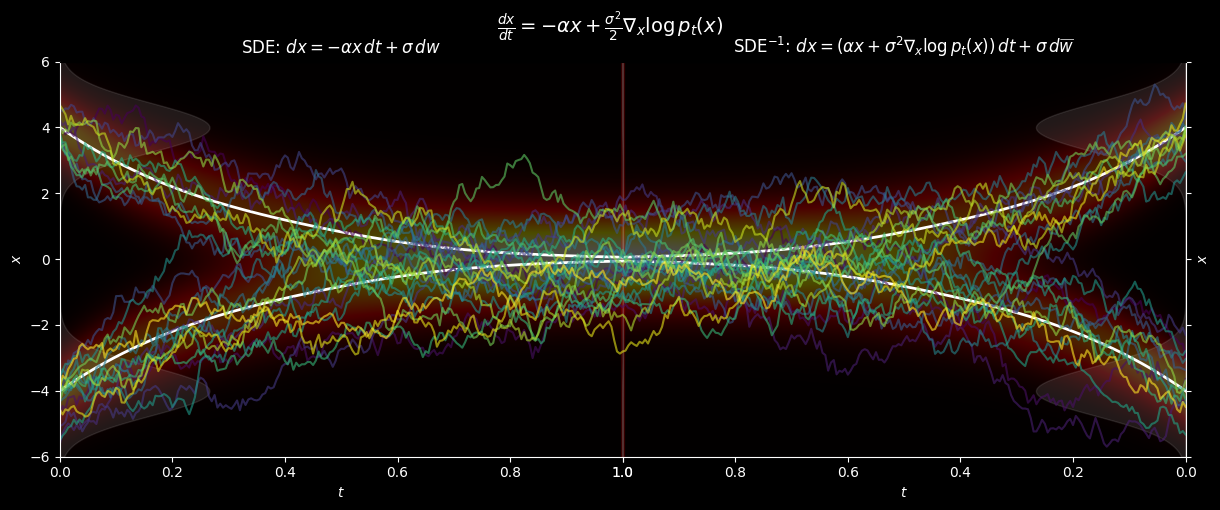

alpha = 3.0, sigma = 5.0


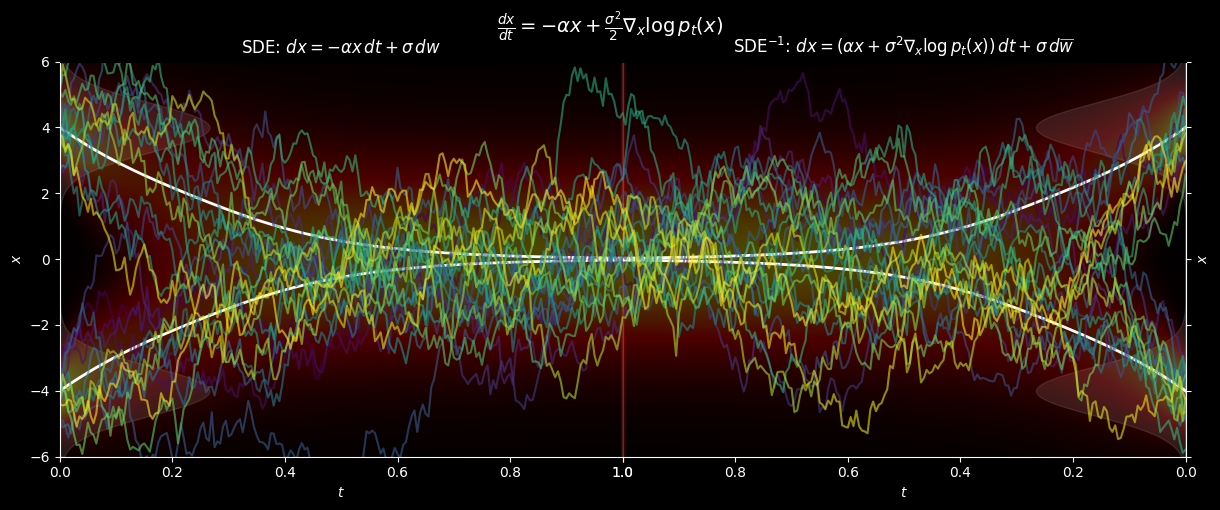

In [2]:
from xaims import coolplots

for alpha in [3.0]:
    for sigma in [2.5, 5.0]:
        print(f'alpha = {alpha}, sigma = {sigma}')
        fig, ax = coolplots.OU_simulation(alpha=alpha, sigma=sigma, N=25, plot_hist=False)
        #fig.savefig('img/OU_simulation.jpeg', dpi=200, bbox_inches='tight')


### Forward-time SDE

The so-called Variance Preserving VP-SDE model can be derived from the DDPM model under limit of infinite number of time steps. However, its direct SDE formulation goes as follows.

The fundamental forward-time SDE underlying most continuous-time diffusion models is

$
\boxed{
d\mathbf{x}(t) = \mathbf{f}(\mathbf{x}, t)\, dt + g(t)\, d\mathbf{w}_t
}
$

with coefficients identified for the VP-SDE case as:

- Drift:
  $
  \mathbf{f}(\mathbf{x}, t) = -\frac{1}{2} \beta(t)\, \mathbf{x}
  $

- Diffusion coefficient:
  $
  g(t) = \sqrt{\beta(t)}
  $

- Linear noise schedule:
  $
  \beta(t) = \beta_0 + (\beta_1 - \beta_0)\, t, \quad \alpha(t) = \exp\left(-\frac{1}{2} \int_0^t \beta(s)\, ds \right), \quad \sigma^2(t) = 1 - \alpha^2(t)
  $

- Standard Brownian motion: $\mathbf{w}_t$

- Variance-Preserving design: $\alpha(t)^2 + \sigma(t)^2 = 1$.

For a linear $\beta(t)$, the integral above has a closed form: $\int_0^t \beta(s)\, ds = \beta_0 t + \frac{1}{2}(\beta_1 - \beta_0) t^2$.

We now identify that VP-SDE can be seen as a time-dependent coefficient **Ornstein–Uhlenbeck process**, but $\alpha$ and $\sigma$ here are not the same as for the OU-process.

### Reverse-time SDE

The fundamental reverse-time SDE is:

$
\boxed{
d\mathbf{x} = \left[ \mathbf{f}(\mathbf{x}, t) - g(t)^2 \nabla_{\mathbf{x}} \log p_t(\mathbf{x}, t) \right] dt + g(t) \, d\bar{\mathbf{w}}_t
}
$

which applied to VP-SDE gives

$
d\mathbf{x} = \left( -\frac{1}{2} \beta(t)\, \mathbf{x} - \beta(t)\, \nabla_{\mathbf{x}} \log p_t(\mathbf{x}) \right)\, dt + \sqrt{\beta(t)}\, d\bar{\mathbf{w}}_t.
$

Now it is clear why we want to learn the score vector field function $ \mathbf{s}_\theta(\mathbf{x}, t) \approx \nabla_{\mathbf{x}} \log p_t(\mathbf{x}) $.


### Conditional Density

The solution to the forward SDE gives:

$
\boxed{
\mathbf{x}_t = \alpha(t) \mathbf{x}_0 + \sigma(t) \boldsymbol{\epsilon}, \quad \boldsymbol{\epsilon} \sim \mathcal{N}(0, \mathbf{I})
}
$

with a corresponding conditional density

$
p(\mathbf{x}_t \mid \mathbf{x}_0) = \mathcal{N}\left(\mathbf{x}_t; \, \alpha(t)\mathbf{x}_0, \, \sigma^2(t) \mathbf{I} \right).
$

The solution to the forward SDE has the properties it allows us to come up with a very efficient training procedure, i.e. we do not need the full time simulation (full joint distribution) to get $\mathbf{x}_t$ from $\mathbf{x}_0$.

**Literature:**

- <a href="https://arxiv.org/abs/2011.13456">Song et al, *Score-Based Generative Modeling through Stochastic Differential Equations*, [arXiv:2011.123456]</a>
- <a href="https://users.aalto.fi/~asolin/sde-book/sde-book.pdf">Särkkä, Solin, *Applied Stochastic Differential Equations*, Cambridge University Press, 2019</a>


---

### A. Training Procedure

The aim is to learn a time dependent and an external variable $c$ conditional score estimator $\mathbf{s}_\theta(\mathbf{x}, t, \mathbf{c}) \simeq \nabla_{\mathbf{x}} \log p_t(\mathbf{x} \mid \mathbf{c})$.

We minimize:

$
\mathcal{L}(\theta) = \mathbb{E}_{t, \mathbf{x}_0, \boldsymbol{\epsilon}} \left[ \lambda(t) \left\| \mathbf{s}_\theta(\mathbf{x}_t, t, \mathbf{c}) + \frac{\boldsymbol{\epsilon}}{\sigma(t)} \right\|^2 \right],
$

where:

- $\lambda(t)$ is a weighting function with $\lambda(t) = g^2(t)$ but alternatives exist (unity, ...)
- $t \sim \mathcal{U}(\varepsilon, 1) $ for numerical stability, to avoid singularity at $t \rightarrow 0$
- $\epsilon \sim \mathcal{N}(0, \mathbf{I})$
- $\mathbf{x}_t = \mathbf{x}_0 + \sigma(t) \epsilon$, in the case of additive noise SDEs

After reparametrization and re-arranging, the denoising score matching loss is computed as:

$
\boxed{
\mathcal{L}(\theta) = \mathbb{E}_{t, \mathbf{x}_0, \epsilon} \left[ \lambda(t) \left\| \epsilon - (- \sigma(t) \mathbf{s}_\theta(\mathbf{x}_t, t, c)) \right\|^2 \right]
}
$


---
### B. Sampling procedure with Euler–Maruyama SDE solver

We sample from the learned model by simulating the reverse-time SDE:

$
d\mathbf{x} = \left[\mathbf{f}(\mathbf{x},t) - g(t)^2 \mathbf{s}_\theta(\mathbf{x}, t, c) \right] dt + g(t) d\bar{\mathbf{w}}
$

This is integrated using the Euler–Maruyama method with a negative time step $ \Delta t < 0 $.

To generate a sample:

1. Initialize:
    $
    \mathbf{x}_T = \sigma(T) \cdot \mathbf{z}, \quad \mathbf{z} \sim \mathcal{N}(0, \mathbf{I})
    $

2. For each $ t = T, T + \Delta t, \dots, \Delta t$:

    $
    \boxed{
    \mathbf{x}_{t + \Delta t} = \mathbf{x}_t + \left[ \mathbf{f}(\mathbf{x}_t,t) - g(t)^2 \mathbf{s}_\theta(\mathbf{x}_t, t, c) \right] \Delta t + g(t) \sqrt{-\Delta t} \cdot \xi, \quad \xi \sim \mathcal{N}(0, \mathbf{I})
    }
    $

3. Return: $\mathbf{x}_0$

We need to be careful not to evaluate exactly at $t = 0$. A cut-off regularization is needed such that $t > \epsilon \sim 10^{-5} ... 10^{-3}$.

---
### C. Sampling procedure with ODE solver

By matching the SDE picture **Fokker-Planck equation** (Forward Kolmogorov) and the density field continuity equation (vector analysis), which are known to be

$
\text{FP:} \, \frac{\partial p(\mathbf{x},t)}{\partial t} = - \nabla \cdot \langle \mathbf{f}(\mathbf{x},t) p(\mathbf{x},t) \rangle + \frac{1}{2} g(t)^2 \nabla_{\mathbf{x}}^2 p(\mathbf{x},t)
$

$
\text{CE:} \, \frac{\partial p(\mathbf{x},t)}{\partial t} = -\nabla \cdot (\mathbf{v}(\mathbf{x},t) p(\mathbf{x},t)).
$

Then with some work, we can derive the corresponding ODE to our SDE as

$\boxed{
\frac{d\mathbf{x}}{dt} = \mathbf{v}(t) = \mathbf{f}(\mathbf{x}, t) - \frac{1}{2} g(t)^2 \mathbf{s}_\theta(\mathbf{x}, t, \mathbf{c})
}
$

This allows deterministic sampling with ODE solvers, e.g. Euler (1st order) or Heun (2nd order). Also the log-density evaluation via infinitesimal change-of-variable formula becomes possible. Note the factor $1/2$ wrt SDE!

The 1st order Euler integrator update is then

$
\boxed{
\mathbf{x}_{t + \Delta t} = \mathbf{x}_t + \left[ \mathbf{f}(t, \mathbf{x}_t) - \frac{1}{2}g(t)^2 \mathbf{s}_\theta(\mathbf{x}_t, t, c) \right] \Delta t
}
$

again with $\Delta t < 0$, because we are going in reverse time.

---

### D. Log-Density Estimation with ODE probability flow

The probability density evolution in the ODE picture can be obtained via the **infitesimal change-of-variables** equation:

$
\frac{d}{dt} \log p(\mathbf{x}, t) = - \nabla_{\mathbf{x}} \cdot \mathbf{v}(\mathbf{x},t) = - \text{Trace}\left( \frac{\partial \mathbf{v}}{ \partial \mathbf{x}} \right)
$

The master formula for the data log-density is obtained via forward integration as

$
\boxed{
\log p(\mathbf{x}_0 \mid \mathbf{c}) = \log p_T(\mathbf{x}_T) + \int_{\epsilon}^T \nabla_{\mathbf{x}} \cdot \mathbf{v}(\mathbf{x}, t, \mathbf{c}) \, dt
}
$

where

- $ \mathbf{x}_0 $: data sample point at time $t = 0$
- $ \mathbf{x}_T $: time evolved point at $t = T$
- $ p_T(\mathbf{x}_T) $: prior (Gaussian) density value at time $T$
- $ \nabla_{\mathbf{x}} \cdot \mathbf{v}(\mathbf{x},t) \equiv \text{div} \, \mathbf{v}(\mathbf{x},t)$: divergence of the vector field

Now computing the divergence in higher dimensions requires significant computational effort, see the Hutchinson Trace estimator.

<details>

<summary><span style="color: red">Hutchinson Trace Estimator (expand)</span></summary>

#### Hutchinson's Sliced Trace Estimator

The divergence $ \nabla_{\mathbf{x}} \cdot \mathbf{v}(\mathbf{x},t,c) $ is computationally expensive in high dimensions, because it requires trace of a Jacobian. Instead, we use **Hutchinson’s stochastic trace estimator**

$
\text{Tr}(A) = \mathbb{E}[\epsilon^T A \epsilon] = \frac{1}{N} \sum_{i=1}^N e_i^T A e_i, \quad \boldsymbol{\epsilon} \sim \mathcal{N}(0, \mathbf{I}) \; \text{or Rademacher} (\text{random} \pm 1)
$

- This integral accounts for **volume change** under the flow
- Allows **computing normalized densities** with a score model
- Enables **maximum likelihood training** (but that is slow)

Thus, applied in our setup

$
\nabla_{\mathbf{x}} \cdot \mathbf{v}(\mathbf{x},t,c) = \text{Tr}(\text{Jac}_{\mathbf{v}}(\mathbf{x},t,c) ) \approx \mathbb{E}_{\boldsymbol{\epsilon}} \left[ \boldsymbol{\epsilon}^\top \text{Jac}_{\mathbf{v}}(\mathbf{x},t,c)\, \boldsymbol{\epsilon} \right],
$

where the first identity comes from the fact that divergence is equal to the Jacobian trace

$
\nabla_{\mathbf{x}} \cdot \mathbf{v}(\mathbf{x},t,c) = \sum_{i=1}^D \frac{\partial v_i(\mathbf{x})}{\partial \mathbf{x}_i}.
$

Now, the Hutchinson is useful because autograd gives us in an efficient way to access the Jacobian-vector products `jvp` (or `vjp`), which are **directional derivatives**:

$
\text{Jac}_{\mathbf{v}}(\mathbf{x},t,c) \mathbf{\epsilon} = \lim_{h \rightarrow 0} \frac{\mathbf{v}(\mathbf{x} + h \mathbf{\epsilon}, t, c) - \mathbf{v}(\mathbf{x},t,c)}{h} = D_{\epsilon} \mathbf{v}(\mathbf{x},t,c).
$

Overall, Hutchinson estimator gives an **unbiased stochastic estimate** of the trace of the Jacobian. However, **the estimator can have high variance** even with a large number of random slices $N$, which can be prohibitive in importance sampling applications, i.e. trying the use the model as an exact proposal density on per event basis. Thus Hutchinson is more suitable for e.g. loss functions or statistical inference, where we are interested in ensemble averages. For variance reduction schemes, see:

<a href="https://arxiv.org/abs/2010.09649">Hutch++: Optimal Stochastic Trace Estimation [arXiv:2010.09649]</a>

**Full Jacobian Trace vs Hutchinson’s Estimator compared**

| Method                        | Time Complexity                  | Accuracy     | Memory Usage | Suitable For       |
|------------------------------|----------------------------------|--------------|--------------|--------------------|
| Full Autograd Jacobian Trace | $ \mathcal{O}(d \cdot C_{\text{net}}) $ | Exact        | High         | Low-dimensional models |
| Hutchinson’s Estimator       | $ \mathcal{O}(N \cdot C_{\text{net}}) $ | Unbiased estimate (high variance for small $N$) | Low | High-dimensional problems |

</details>

<br>

---

## Diffusion vs Flow Matching ?

*Flow Matching* is an evolution of the diffusion type model training strategies, in the category of neural ODE methods. It is used to train continuous normalizing flows, the vector field ODE presented earlier.

Instead of (denoising) score matching, flow matching tries to match the ODE velocity vector field directly. It can be shown that under certain choises of the noise schedulers, Gaussian Flow Matching is equivalent with DDIM diffusion.

Flow matching allows one to construct more straight and constrained 'paths' during training, e.g. using Optimal Transport solver. This equals typically to more efficient sampling due to less time steps needed. For more discussion, see:

<a href="https://diffusionflow.github.io">Gao et al., *Diffusion Meets Flow Matching: Two Sides of the Same Coin*, [DeepMind blog]</a>

<a href="https://arxiv.org/abs/2210.02747">Lipman et al., *Flow Matching for Generative Modeling*, [arXiv:2210.02747]</a>

<a href="https://arxiv.org/abs/2412.06264">Lipman et al, *Flow Matching Guide and Code*, [arXiv:2412.06264]</a>


<br>

---
## Conditionalization Technology

We somewhat without questioning assumed that the external variable $c$ conditionalization can be directly concatenated as input to the relevant MLPs in the flow and diffusion models. However, for better expressivity, higher quality and easier learning, further modelling approaches may be needed. Some of these techniques might not be theoretically always well motivated.

### Input embedding

Some options are:

1. Direct concat of type: `x_tilde = concat([x,c])`
2. Embedding map, e.g. learned or sinusoidal: `x_tilde = concat([x, cond_embed_net(c)])`
3. Cross-attention with respect to `cond_embed_net(c)`, when working with Transformer models; graphs, sequences, sets ...
4. <a href="https://arxiv.org/abs/1709.07871">FiLM model</a> like architectures which have special architecture regarding the conditional input.

### Conditional base
Sometimes the *base distribution* is also made conditional. E.g. in the case of normalizing flows we use a fixed mean-variance base $\mathbf{z} \sim \mathcal{N}(0,1)$, one can make it parametric:

$
\mathbf{z} \sim p_Z(\mathbf{z}∣c) = \mathcal{N}(\mu_{\phi}(c), \Sigma_{\phi}(c)),
$

where $\mu_{\phi}(c)$ and $\Sigma_{\phi}(c)$ come from a separate neural net $\phi$, trained together with the flow. That is:

```python
mu, log_std = base_conditioner_net(c)
base_dist   = torch.distributions.Normal(mu, log_std.exp())
log_pz      = base_dist.log_prob(z).sum(dim=1)
```

### Dequantization

It may be beneficial to add carefully designed noise to $c$ during training if $c$ is sampled from a discrete lattice but the variable is actually continuous, for example when we have a set of simulation samples at discrete parameter points. This is known as 'dequantization', which can make the neural network more well behaved. Inverse CDF quantization is one technique, which can be employed, which essentially fills the values randomly between two discrete points.

Note that this technique can be very crucial in the $x$-space (data-space) for normalizing flows, but may be critical also in the conditional space.

### Guidance and steering

Without strong conditioning, samples may ignore $c$, heuristically speaking. One trick is *guidance* aka steering the generation toward directions that increase the likelihood of being consistent with $c$.

<details>
<summary><span style="color: red">Guidance Recipe (expand)</span></summary>

<br>

Train a single model to predict both **conditional** and **unconditional** outputs by randomly dropping the condition during training.

At inference, interpolate between the two to guide generation toward the condition.

#### Training

Given a condition $c$, drop it with probability $p_{\text{drop}}$, replacing it with $\varnothing$, which is e.g. a zero vector embedding:

$
c' = \begin{cases}
c & \text{with probability } 1 - p_{\text{drop}} \\
\varnothing & \text{with probability } p_{\text{drop}}
\end{cases}
$

Train model $ \phi(x, t, c') $, where $ \phi = s_\theta $ is the **score** for diffusion models and $\phi = v_\theta $ is the **vector field** for flow matching.

#### Inference

Given condition $ c $, compute both:
- $ \phi_c = \phi(x, t, c) $ — **conditional output**
- $ \phi_u = \phi(x, t, \varnothing) $ — **unconditional output**

Interpolate:
$
\phi_G = (1 + g) \cdot \phi_c - g \cdot \phi_u,
$

where $g > 0$ is a guidance scale parameter. Then finally plug-in $\phi_G$ into the inference equations.

**References**

<a href="https://arxiv.org/abs/2207.12598">Ho et al., *Classifier-Free Diffusion Guidance*, [arXiv:2207.12598]</a>

<a href="https://arxiv.org/abs/2406.02507">Karras et al., *Guiding a Diffusion Model with a Bad Version of Itself*, [arXiv:2406.02507]</a>

<a href="https://arxiv.org/abs/2501.06848">Singhal et al., *A General Framework for Inference-time Scaling and Steering of Diffusion Models (Feynman-Kac steering)*, [arXiv:2501.06848]</a>

</details>

<br>

---
## Check your knowledge

1. **What are the key features of Normalizing Flows?**

2. **What is the difference between discrete-time and continuous-time Diffusion models?**

4. **What are the main pros & cons of classic Normalizing Flows vs Diffusion?**

5. **How are Diffusion and Flow Matching related?**
